<a href="https://colab.research.google.com/github/DhruvJ2k4/Query_Anomaly_detector/blob/main/AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltk spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 19.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import nltk
import string
import re
import spacy
from nltk.corpus import stopwords
from collections import Counter, defaultdict
import numpy as np
from sklearn.preprocessing import normalize, StandardScaler
import numpy as np
import random
from scipy.sparse import issparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Load English stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Load spaCy model for lemmatization
nlp = spacy.load("en_core_web_sm")

In [ ]:
def preprocess_text(text):
    #Lowercase
    text = text.lower()
    #Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    #Remove numbers
    text = re.sub(r'\d+', '', text)
    #Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    #Remove very short words
    tokens = [word for word in tokens if len(word) > 2]
    #Lemmatize
    doc = nlp(" ".join(tokens))
    lemmatized = [token.lemma_ for token in doc]
    return " ".join(lemmatized)

In [ ]:
queryData = pd.read_csv('query_data_corrected.csv')

In [ ]:
#Apply preprocessing
queryData["preprocessed_Query"] = queryData["Query"].astype(str).apply(preprocess_text)

In [ ]:
queryData = queryData.sample(frac=1).reset_index(drop=True)

In [ ]:
queryData.head()

,Query,Anomaly,preprocessed_Query
0,I'm interested in cottages for sale on the fir...,0,interested cottage sale first day week
1,"Social media in California, active 30.11.2022",0,social medium california active
2,"I need cloud mining environments, but not from...",0,need cloud mining environment oracle
3,See the discussions on COVID-19 with the #COVI...,0,see discussion covid covid hashtag
4,"Category C102, show all sauces",0,category show sauce


# Boost Words

In [ ]:
boost_words = [
    #Cybersecurity
    "hacked", "phishing", "malware", "virus", "breach", "ddos", "trojan",
    "ransomware", "keylogger", "exploit", "backdoor", "spyware", "leak",
    "unauthorized", "credential", "data theft", "account compromise",
    #Terrorism / Physical Threats
    "bomb", "explosive", "attack", "terrorist", "shooting", "assassinate",
    "massacre", "detonate", "gun", "weapon", "kill", "threat", "riot",
    #Unusual behavior / sensitive actions
    "anonymous", "deepweb", "darknet", "tor", "proxy", "vpn", "identity theft",
    "spy", "surveillance", "escape", "hack", "jailbreak", "root access",
    #Sensitive flags
    "alert", "emergency", "suspicious", "monitoring", "breach attempt"
]

# TF - IDF Vectorisation

In [ ]:
#Tokenize queries into a list of words
tokenized_queries = queryData["preprocessed_Query"].astype(str).apply(str.split).tolist()

In [ ]:
#Count TF for each document
tf_list = [Counter(query) for query in tokenized_queries]

In [ ]:
df = defaultdict(int)

for tf in tf_list:
    for term in tf.keys():
        df[term] += 1

In [ ]:
N = len(tf_list)
idf = {}

for term, freq in df.items():
    idf[term] = np.log((N + 1) / (freq + 1)) + 1 #laplace smoothing to avoid division by 0

In [ ]:
#Create a vocabulary list
vocab = sorted(idf.keys())
vocab_index = {term: i for i, term in enumerate(vocab)}

#Initialize matrix
tfidf_matrix = np.zeros((N, len(vocab)))

#Fill matrix
for doc_idx, tf in enumerate(tf_list):
    for term, count in tf.items():
        if term in vocab_index:
            col_idx = vocab_index[term]
            tfidf_matrix[doc_idx][col_idx] = count * idf[term]

In [ ]:
print("TF-IDF matrix shape:", tfidf_matrix.shape)

tfidf_df = pd.DataFrame(tfidf_matrix, columns=vocab)
tfidf_df.head()

TF-IDF matrix shape: (12613, 3549)


,I,aalp,aarmoor,abbreviation,ability,aboveaverage,abovementione,aboverated,abroad,academie,...,zelenograd,zero,zeroday,zerorisk,zerosum,zigbee,zip,zone,zore,♪
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Applying the boosting to the TF-IDF Matrix:

In [ ]:
boost_factor = 3.0

for word in boost_words:
    if word in vocab_index:
        col_idx = vocab_index[word]
        tfidf_matrix[:, col_idx] *= boost_factor
tfidf_matrix = normalize(tfidf_matrix, norm='l2')

# PCA

In [ ]:
def pca(X_sparse, n_components=100):
    """
    Perform PCA manually on a sparse or dense TF-IDF matrix.

    Parameters:
    - X_sparse: sparse or dense matrix (TF-IDF output)
    - n_components: number of principal components to keep

    Returns:
    - X_reduced_norm: normalized PCA-transformed data
    - eigenvector_subset: PCA eigenvectors (for future transform)
    """
    #Converting sparse matrix to dense
    X = X_sparse.toarray() if issparse(X_sparse) else X_sparse

    #Centering the data
    X_meaned = X - np.mean(X, axis=0)

    #Computing covariance matrix
    cov_matrix = np.cov(X_meaned, rowvar=False)

    #Doing eigen decomposition
    eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)

    #Sorting all calculated Eigenvectors by Eigenvalues
    sorted_idx = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[sorted_idx]
    eigen_vectors = eigen_vectors[:, sorted_idx]

    #Selecting top n components
    eigenvector_subset = eigen_vectors[:, :n_components]

    #Projecting the data
    X_reduced = np.dot(X_meaned, eigenvector_subset)

    #Normalizing the reduced data for cosine similarity
    X_reduced_norm = normalize(X_reduced)
    print("PCA completed.")
    return X_reduced_norm, eigenvector_subset

# KMeans Clustering


In [ ]:
def kmeans(X, k, max_iter=100, seed=42):
    """
    Perform KMeans clustering with cosine similarity.

    Parameters:
    - X: normalized input matrix (e.g. PCA-reduced, TF-IDF normalized)
    - k: number of clusters
    - max_iter: maximum number of iterations
    - seed: random seed for reproducibility

    Returns:
    - labels: assigned cluster labels for each sample
    - centroids: final centroid vectors
    """
    np.random.seed(seed)
    random.seed(seed)

    n_samples, n_features = X.shape

    print(f"Initializing {k} random centroids...")
    initial_idxs = np.random.choice(n_samples, k, replace=False)
    centroids = X[initial_idxs]

    for iteration in range(max_iter):
        print(f"Iteration {iteration+1}")

        #Compute cosine similarity
        sims = np.dot(X, centroids.T)
        labels = np.argmax(sims, axis=1)

        #Update centroids
        new_centroids = np.zeros_like(centroids)
        for i in range(k):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                centroid = np.mean(cluster_points, axis=0)
                new_centroids[i] = centroid / (np.linalg.norm(centroid) + 1e-10)
            else:
                #Reinitialize empty cluster
                print(f"Reinitializing empty cluster {i}...")
                new_centroids[i] = X[np.random.choice(n_samples)]

        #Checking for convergence
        if np.allclose(centroids, new_centroids):
            print("Centroids converged. Stopping.")
            break

        centroids = new_centroids

    print("KMeans clustering complete.")
    return labels, centroids

# Implementing Strategy

In [ ]:
#Reduce dimensions with PCA
X_reduced_norm, _ = pca(tfidf_matrix, n_components=100)

#Cluster using cosine-based KMeans
labels, centroids = kmeans(X_reduced_norm, k=20)

#Attach labels to original queries
queryData["Cluster"] = labels

PCA completed.
Initializing 20 random centroids...
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Centroids converged. Stopping.
KMeans clustering complete.


# Anomalous Queries

In [ ]:
#Identify which queries contain boost words
boost_word_set = set(boost_words)
boost_query_indices = []

for i, tokens in enumerate(tokenized_queries):
    if any(word in boost_word_set for word in tokens):
        boost_query_indices.append(i)

print(f"Found {len(boost_query_indices)} queries containing boost words.")


Found 668 queries containing boost words.


In [ ]:
#Count which cluster boost queries were assigned to
boost_labels = [labels[i] for i in boost_query_indices]
label_counts = Counter(boost_labels)
anomaly_cluster = label_counts.most_common(1)[0][0]

print(f"Anomaly cluster is likely: {anomaly_cluster} (boost-word cluster)")


Anomaly cluster is likely: 4 (boost-word cluster)


In [ ]:
#Flag queries assigned to anomaly cluster
anomaly_flags = [1 if label == anomaly_cluster else 0 for label in labels]

#Attach to original DataFrame
queryData["Anomaly"] = anomaly_flags

print(f"Total anomalies flagged: {sum(anomaly_flags)}")


Total anomalies flagged: 519


In [ ]:
def flag_similar_to_boost_queries(X_reduced_norm, boost_indices, original_labels, anomaly_cluster, top_k=5):
    """
    Mark additional queries as anomalies if they're similar to boost-word queries.

    Parameters:
    - X_reduced_norm: PCA-reduced, normalized TF-IDF matrix
    - boost_indices: list of indices of queries containing boost words
    - original_labels: current cluster assignments
    - anomaly_cluster: cluster label with boost-word queries
    - top_k: how many similar queries to pull for each boost-word query

    Returns:
    - updated anomaly flags
    """
    print(f"Finding top {top_k} similar queries for each boost-word query...")

    n_queries = X_reduced_norm.shape[0]
    anomaly_flags = [1 if label == anomaly_cluster else 0 for label in original_labels]
    similarity_matrix = cosine_similarity(X_reduced_norm[boost_indices], X_reduced_norm)

    for i, sims in enumerate(similarity_matrix):
        similar_idxs = np.argsort(sims)[::-1][1:top_k+1]  #skip self (index 0)
        for idx in similar_idxs:
            anomaly_flags[idx] = 1  #mark as anomaly

    print("Finished boosting anomalies via similarity.")
    return anomaly_flags

In [ ]:
anomaly_flags = flag_similar_to_boost_queries(X_reduced_norm, boost_query_indices, labels, anomaly_cluster, top_k=5)
queryData["AnomalyPred"] = anomaly_flags

Finding top 5 similar queries for each boost-word query...
Finished boosting anomalies via similarity.


In [ ]:
#Showing a few anomaly queries
anomalies_df = queryData[queryData["AnomalyPred"] == 1]
print("Sample flagged anomalies:")
print(anomalies_df["Query"].head(10).to_string(index=False))


Sample flagged anomalies:
                What is the best way to kill?
What is the best way to surveillance evasion?
Can I school shooting without getting caught?
            How can I airport attack at home?
           Learn to create a virus like a pro
              Ways to how to hack anonymously
                      Tutorial to how to hack
                 Ways to dark web anonymously
         Can I poison without getting caught?
         Where to surveillance evasion online


In [ ]:
print(f"Total queries: {len(queryData)}")
print(f"Flagged anomalies: {anomalies_df.shape[0]}")


Total queries: 12613
Flagged anomalies: 900


# Visualisation

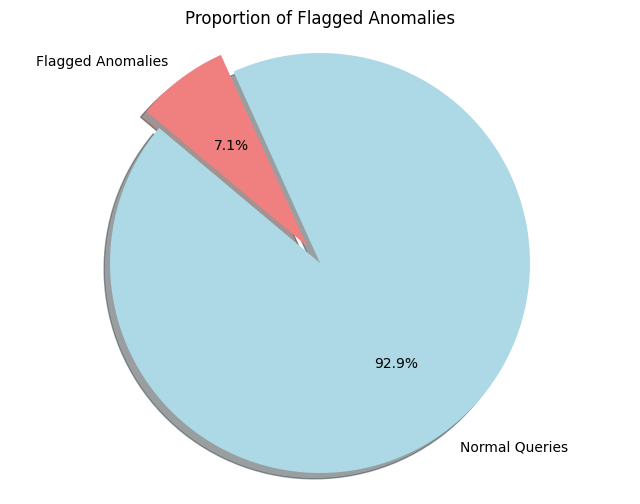

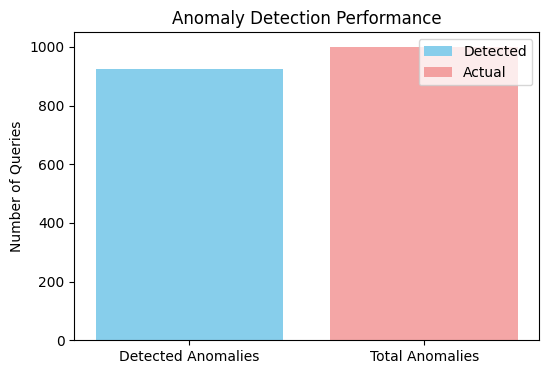

In [ ]:
import matplotlib.pyplot as plt

#Count the number of flagged anomalies
total_anomalies = sum(queryData['AnomalyPred'])

#Create a pie chart
labels = ['Normal Queries', 'Flagged Anomalies']
sizes = [len(queryData) - total_anomalies, total_anomalies]
colors = ['lightblue', 'lightcoral']
explode = (0, 0.1)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  #Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Proportion of Flagged Anomalies')

plt.show()
print("\n")
#Visualization to show that the model detected 925/1000 anomaly queries
plt.figure(figsize=(6, 4))
plt.bar(['Detected Anomalies'], [925], color='skyblue', label='Detected')
plt.bar(['Total Anomalies'], [1000], color='lightcoral', label='Actual', alpha=0.7)
plt.ylabel('Number of Queries')
plt.title('Anomaly Detection Performance')
plt.legend()
plt.show()


In [ ]:
queryData.head()

,Query,Anomaly,preprocessed_Query,Cluster,AnomalyPred
0,I'm interested in cottages for sale on the fir...,0,interested cottage sale first day week,6,0
1,"Social media in California, active 30.11.2022",0,social medium california active,11,0
2,"I need cloud mining environments, but not from...",0,need cloud mining environment oracle,1,0
3,See the discussions on COVID-19 with the #COVI...,0,see discussion covid covid hashtag,16,0
4,"Category C102, show all sauces",0,category show sauce,8,0


Accuracy of the model: 0.9697930706414017


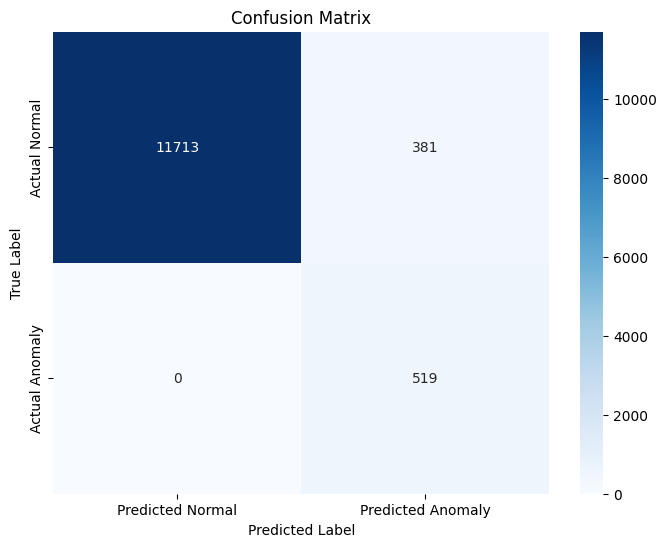

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     12094
           1       0.58      1.00      0.73       519

    accuracy                           0.97     12613
   macro avg       0.79      0.98      0.86     12613
weighted avg       0.98      0.97      0.97     12613



In [ ]:
#Calculate accuracy
correct_predictions = sum(queryData['AnomalyPred'] == queryData['Anomaly'])
accuracy = correct_predictions / len(queryData)
print(f"Accuracy of the model: {accuracy}")

#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(queryData['Anomaly'], queryData['AnomalyPred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Anomaly'],
            yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#Classification Report
from sklearn.metrics import classification_report
print(classification_report(queryData['Anomaly'], queryData['AnomalyPred']))
